In [7]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date

import regionmask

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

### get data

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important;}</style>"))

In [156]:
%%time 
## 20CR apcp
filelist=[]
for i in range(1981,2014,1):
    filelist.append(f'/Users/dongxiay/Documents/data/daily/apcp.{i}.nc')
ds1=xr.open_mfdataset(filelist,combine='by_coords')
ds=ds1['apcp'].loc[:,-45:0,100:160]

##Oliver MJO
df=pd.read_csv("/Users/dongxiay/Documents/data/MJO_ot12.csv")
df['time']=pd.to_datetime(df[['year','month','day']])
df=df.set_index('time').drop(columns=['year','month','day'])
df.loc[df['amplitude'].lt(1) ,'phase'] = 0

##NINO3.4
dateparser = lambda d: pd.datetime.strptime(d,'%Y%m%d')
df2=pd.read_csv('http://climexp.knmi.nl/data/inino34_daily.dat',
                skiprows=12,delim_whitespace=True,
                names=['time','enso'],
                parse_dates=['time'],
                date_parser=dateparser)
df2=df2.set_index(df2['time']).drop(columns='time')
df2.loc[df2['enso'].lt(-1) ,'watch'] = -1
df2.loc[df2['enso'].gt(1) ,'watch'] = 1
df2.loc[(df2['enso']>(-1)) & (df2['enso']<(1)),'watch']=0

##merge
dfmjo=df.loc[(df.index >= ds.time.min().values) & (df.index <= ds.time.max().values)][['amplitude','phase']]
dfenso=df2.loc[(df2.index >= ds.time.min().values) & (df2.index <= ds.time.max().values)]['watch']
data=xr.merge([ds,dfmjo.to_xarray(),dfenso.to_xarray()],join='inner').load()

data

<timed exec>:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


CPU times: user 15 s, sys: 1.41 s, total: 16.4 s
Wall time: 18.3 s


<xarray.Dataset>
Dimensions:    (time: 11810, lat: 46, lon: 61)
Coordinates:
  * time       (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2013-12-31
  * lat        (lat) float32 -45.0 -44.0 -43.0 -42.0 ... -3.0 -2.0 -1.0 0.0
  * lon        (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
Data variables:
    apcp       (time, lat, lon) float32 0.3625 0.3125 0.2625 ... 1.025 0.875
    amplitude  (time) float64 1.773 1.754 1.641 1.486 ... 0.1155 0.2596 0.4505
    phase      (time) int64 2 2 2 2 2 2 2 2 2 2 3 3 ... 0 0 0 0 0 0 0 0 0 0 0 0
    watch      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/14)
    long_name:         daily mean 3-hourly accumulated total precipitation at...
    units:             kg/m^2
    GRIB_name:         APCP
    var_desc:          Precipitation amount
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3mo Dai...
    level_desc:        Surface
    ...                ...
    standard_name:     precipitation_amount
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ 0.    35.625]

###  Ratio=Prob/baseline

Prob= (number of days when rainfall exceeding the 67% threshold (THR67) for MJO phase 1)
/ (number of days that is in MJO phase 1)

baseline= (number of days when rainfall exceeding the THR67) / (total days for 34 years)

In [14]:
def func(ds):
    return ds['apcp'].count('time') / len(ds['time'])


In [99]:
%%time
THR=0.67
THR_threshold = data['apcp'].where(data['apcp']!=0).chunk(dict(time=-1)).quantile(THR, dim='time')


CPU times: user 161 ms, sys: 59.2 ms, total: 221 ms
Wall time: 221 ms


In [100]:
%%time
baseline = data.where(data['apcp'] >= THR_threshold)['apcp'].count('time') / len(data['time'])
baseline=baseline.compute()
result = data.where(data.apcp >= THR_threshold).groupby(data.phase).apply(func).compute()
ratio= result/baseline
ratio

CPU times: user 2.24 s, sys: 194 ms, total: 2.43 s
Wall time: 2.31 s


<xarray.DataArray 'apcp' (phase: 9, lat: 46, lon: 61)>
array([[[1.04710745, 1.04938084, 1.04765453, ..., 1.02828809,
         1.02577369, 1.02531161],
        [1.06137544, 1.06323856, 1.06140241, ..., 1.0425094 ,
         1.03800391, 1.03954786],
        [1.05837012, 1.06870682, 1.07118004, ..., 1.05990403,
         1.04987985, 1.05161911],
        ...,
        [0.81725292, 0.85441035, 0.89178071, ..., 0.90431965,
         0.91525685, 0.90034241],
        [0.81593477, 0.83812363, 0.94879478, ..., 0.93127237,
         0.91919759, 0.9124993 ],
        [0.81267941, 0.84873827, 0.97443194, ..., 0.9487227 ,
         0.9553573 , 0.93989115]],

       [[1.04411376, 1.04563458, 1.03168226, ..., 0.99190771,
         0.99218393, 1.00764229],
        [1.03029598, 1.05752203, 1.06030865, ..., 0.95288326,
         0.97860131, 1.00619387],
        [1.02589852, 1.0026535 , 1.01636349, ..., 0.96177746,
         0.9540075 , 0.97804859],
...
        [0.63626521, 0.61269033, 0.93240145, ..., 1.19691902,
         1.17199603, 1.18708049],
        [0.65665833, 0.69155321, 0.90516038, ..., 1.1382405 ,
         1.14888214, 1.17328148],
        [0.65155498, 0.81640458, 0.81283307, ..., 1.12357616,
         1.1784195 , 1.15125158]],

       [[0.92809166, 0.91187232, 0.93616482, ..., 1.01468367,
         1.00420687, 0.99845228],
        [0.89712509, 0.9037268 , 0.9027145 , ..., 0.94147583,
         0.93526164, 0.94200758],
        [0.89169778, 0.89089023, 0.88179611, ..., 0.93304863,
         0.95386321, 0.96746725],
        ...,
        [1.18830708, 1.30073804, 1.32912115, ..., 1.11659563,
         1.13228842, 1.1644982 ],
        [1.34022133, 1.43099479, 1.2365121 , ..., 1.01484564,
         1.0403888 , 1.0537025 ],
        [1.40552825, 1.35813204, 1.22625133, ..., 0.89068783,
         0.9057069 , 0.94292928]]])
Coordinates:
  * lat       (lat) float32 -45.0 -44.0 -43.0 -42.0 -41.0 ... -3.0 -2.0 -1.0 0.0
  * lon       (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
    quantile  float64 0.67
  * phase     (phase) int64 0 1 2 3 4 5 6 7 8

In [ ]:
### mask ocean   
# fmask=xr.open_dataset("/Users/dongxiay/Documents/data/daily/land.nc")
# mask = fmask['land'].loc['1836-01-01',-45:0,100:160]
# ds_l = ds.where(mask)

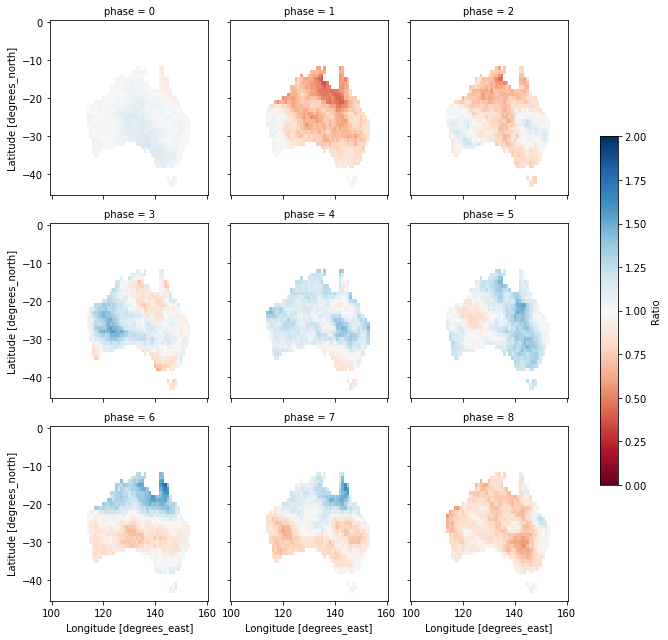

In [101]:
import regionmask
mask = regionmask.defined_regions.natural_earth.countries_110.mask(ratio)
AU_index = regionmask.defined_regions.natural_earth.countries_110.map_keys('AU')
ratio_AU = ratio.where(mask == AU_index)

cbar_kwargs = {'orientation':'vertical', 'shrink':0.6, 'label':'Ratio'}
ratio_AU.plot(col='phase', col_wrap=3, size=3,
             cmap='RdBu', vmin=0, vmax=2,
             cbar_kwargs=cbar_kwargs)

###  Plot

In [ ]:
# import NCL colormap
! pip install cmaps
import cmaps

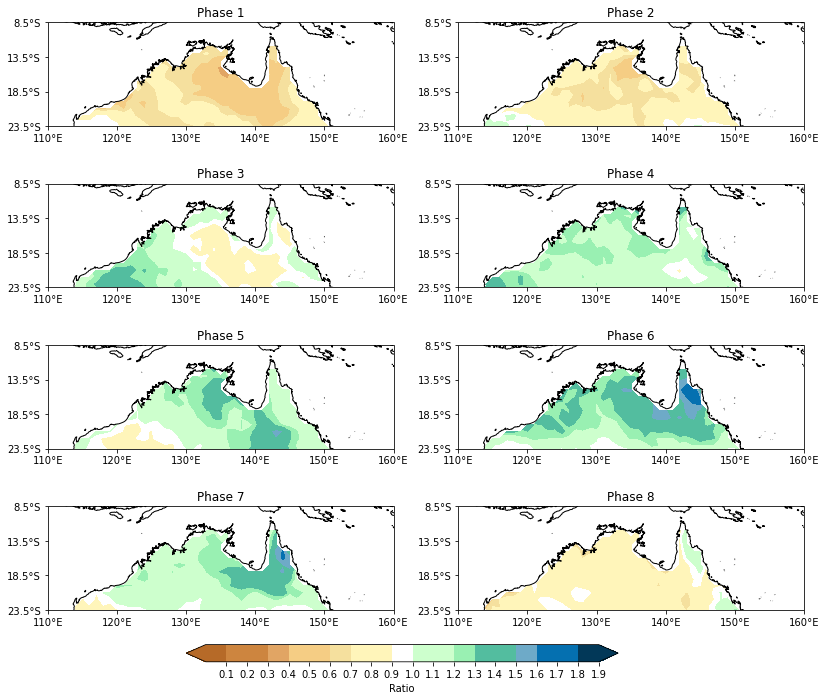

In [102]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 


leftlon, rightlon, lowerlat, upperlat = (110,160,-23.5,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

title=[]
for i in range(1,9,1):
    title.append(f'Phase {i}')
   
fig = plt.figure(figsize=(12,8))

for i in range(4):
    for j in range(2):
        ax = fig.add_axes([0.1+j*0.475, 1.5-i*0.28, 0.4, 0.3],projection = ccrs.PlateCarree())
#         ax.set_title('({})'.format(title[i,j]),loc='left',fontsize=14)
        ax.set_extent(img_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE) 
        ax.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lowerlat,upperlat+5,5), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.title.set_text(title[i*2+j])
        c = ax.contourf(THR_threshold['lon'],THR_threshold['lat'],ratio_AU[i*2+j+1,:,:],
                        levels=np.arange(0,2,0.1),
                        extend='both' ,
                        cmap=cmaps.precip_diff_12lev,
                        transform=ccrs.PlateCarree()) 
        
#colorbar, You would want to make sure the colorbar always sits in the same axes. 
# To this end, you may create a colorbar axes (cax) outside the loop
fig.colorbar(c, cax=fig.add_axes([0.26, 0.63, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'Ratio', 
             ticks=np.arange(0.1,2.1,0.1),
             shrink=0.7)

12053

In [154]:
dfmjo

,amplitude,phase,phase_50
time,,,
1981-01-01,1.330600,3,NaN
1981-01-02,1.497400,4,NaN
1981-01-03,1.589900,4,NaN
1981-01-04,1.587300,4,NaN
1981-01-05,1.508400,4,NaN
...,...,...,...
2013-12-27,0.047333,0,0.0
2013-12-28,0.040611,0,0.0
2013-12-29,0.115490,0,0.0


In [157]:
dfmjo

,amplitude,phase
time,,
1981-01-01,1.330600,3
1981-01-02,1.497400,4
1981-01-03,1.589900,4
1981-01-04,1.587300,4
1981-01-05,1.508400,4
...,...,...
2013-12-27,0.047333,0
2013-12-28,0.040611,0
2013-12-29,0.115490,0


In [158]:
%%time
def create_lead_lag_features(df_, cols, steps):
    df = df_.copy()
    for col in cols:
        for stp in steps:
            df[f"{col}_{stp}"] = df[col].shift(stp)
            df=df.reset_index()
            n_nan = stp
            df.loc[0:n_nan-1, f"{col}_{stp}"] = df.loc[len(df)-stp:, f"{col}_{stp}"].values
            df = df.set_index('time')
    return df
    
# add lagging 
dfmjos = create_lead_lag_features(dfmjo, ['phase'], np.arange(50,(len(dfmjo['phase'])-50),7))


#loop the end back to the beginning 




CPU times: user 2min 25s, sys: 2min 17s, total: 4min 42s
Wall time: 4min 44s


In [159]:
dfmjos

,amplitude,phase,phase_50,phase_57,phase_64,phase_71,phase_78,phase_85,phase_92,phase_99,...,phase_11936,phase_11943,phase_11950,phase_11957,phase_11964,phase_11971,phase_11978,phase_11985,phase_11992,phase_11999
time,,,,,,,,,,,,,,,,,,,,,
1981-01-01,1.330600,3,5.0,0.0,8.0,0.0,0.0,0.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,1.497400,4,5.0,0.0,8.0,0.0,0.0,0.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-03,1.589900,4,6.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-04,1.587300,4,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-05,1.508400,4,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-27,0.047333,0,0.0,8.0,0.0,1.0,6.0,0.0,0.0,5.0,...,0.0,0.0,5.0,4.0,2.0,2.0,8.0,8.0,6.0,0.0
2013-12-28,0.040611,0,0.0,8.0,0.0,1.0,6.0,0.0,0.0,5.0,...,0.0,0.0,5.0,4.0,3.0,2.0,1.0,8.0,6.0,0.0
2013-12-29,0.115490,0,0.0,8.0,0.0,0.0,6.0,0.0,0.0,5.0,...,7.0,0.0,5.0,4.0,3.0,2.0,1.0,8.0,7.0,0.0


In [145]:
df.loc[0:n_nan, f"{col}_{stp}"].values.shape

(51,)